In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os, shutil
from tqdm import tqdm
import pickle
import math

from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet152
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,Input
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend, layers, models,utils
from keras.utils import multi_gpu_model
from keras_efficientnets.efficientnet import EfficientNetB3
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11327206114415502639
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7061687501
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12613411226197925410
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


# 预处理

In [45]:
data_dir = './{}/'
nb_class = len(os.listdir(data_dir.format('train')))
data = {}
for i in ['train', 'valid']:
    data[i] = {x: os.listdir(data_dir.format(i)+x) for x in os.listdir(data_dir.format(i))}

检查两个数据集有没有重叠

In [46]:
print(any([data['valid']['cat'][x] in data['train']['cat'] for x in range(len(data['valid']['cat']))]))
print(any([data['valid']['dog'][x] in data['train']['dog'] for x in range(len(data['valid']['dog']))]))

False
False


## 图像变换

```python
datagen = {'train': image.ImageDataGenerator(
   preprocessing_function=preprocess_input,
#     rotation_range=20
#     ,width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
    horizontal_flip=True
#     ,vertical_flip=True
),
           'valid':image.ImageDataGenerator(
   preprocessing_function=preprocess_input
)
          }
```

或者简单写法便于一个个增删：

In [47]:
datagen = {x: image.ImageDataGenerator(preprocessing_function=preprocess_input) for x in data.keys()}
# datagen['train'].horizontal_flip = True
datagen['train'].rotation_range = 20

In [48]:
im_width, im_height = 224, 224
batch_size = 128

generator = {x: datagen[x].flow_from_directory(
    data_dir.format(x),
    target_size=(im_width, im_height),
    batch_size=batch_size,
    seed = 123,
    class_mode = 'binary',
    shuffle=True      
) for x in datagen.keys()}

generator['valid'].shuffle = False

Found 16662 images belonging to 2 classes.
Found 8208 images belonging to 2 classes.


## 建立模型

选择三个模型：

In [49]:
model_dict = {'ResNet50': ResNet50, 'ResNet152': ResNet152, 'EfficientNetB3': EfficientNetB3}

model_name = 'ResNet152'

载入模型并排除顶部的全连接层。

In [50]:
# tf.reset_default_graph() 
if model_name == 'ResNet152':
    model_base = ResNet152(weights = 'imagenet', include_top = False, input_shape = (im_width, im_height, 3),
                           backend = backend, layers = layers, models = models, utils = utils)
else:
    model_base = model_dict[model_name](weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))

# 
# model_base = EfficientNetB3(weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))

添加自己的层：

In [51]:
model = Sequential()
model.add(model_base)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.75))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))

或者这种写法：
```python
x = model_base.output
# x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5,)(x)
# x = Dense(500, activation='relu')(x)
# x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=model_base.input, outputs=output)
```

查看冻结层前后的可训练层数：

In [52]:
print('Number of trainable weights befor freezing the model_base:', len(model.trainable_weights))
# for layer in model.layers[:173]:
#     layer.trainable = False
model_base.trainable = False
print('Number of trainable weights after freezing the model_base:', len(model.trainable_weights))

Number of trainable weights befor freezing the model_base: 624
Number of trainable weights after freezing the model_base: 4


In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 501       
Total params: 59,395,945
Trainable params: 1,025,001
Non-trainable params: 58,370,944
_________________________________________________________________


编译模型：

In [54]:
lr = 0.001
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(lr=lr), metrics=["accuracy"])

## 训练模型

In [55]:
epochs = 20
history = model.fit_generator(generator['train'],
                              steps_per_epoch=math.ceil(generator['train'].samples / batch_size),
                              epochs=epochs,
                              validation_data=generator['valid'],
                              validation_steps=math.ceil(generator['valid'].samples / batch_size),
#                               callbacks=[early_stopping],
                              verbose = 2)

Epoch 1/20
 - 198s - loss: 0.1107 - acc: 0.9576 - val_loss: 0.0423 - val_acc: 0.9854
Epoch 2/20
 - 182s - loss: 0.0596 - acc: 0.9779 - val_loss: 0.0445 - val_acc: 0.9861
Epoch 3/20
 - 182s - loss: 0.0588 - acc: 0.9780 - val_loss: 0.0333 - val_acc: 0.9903
Epoch 4/20
 - 182s - loss: 0.0523 - acc: 0.9806 - val_loss: 0.0363 - val_acc: 0.9892
Epoch 5/20
 - 182s - loss: 0.0433 - acc: 0.9832 - val_loss: 0.0509 - val_acc: 0.9854
Epoch 6/20
 - 182s - loss: 0.0438 - acc: 0.9832 - val_loss: 0.0334 - val_acc: 0.9905
Epoch 7/20
 - 182s - loss: 0.0443 - acc: 0.9844 - val_loss: 0.0486 - val_acc: 0.9870
Epoch 8/20
 - 182s - loss: 0.0391 - acc: 0.9850 - val_loss: 0.0333 - val_acc: 0.9915
Epoch 9/20
 - 182s - loss: 0.0392 - acc: 0.9861 - val_loss: 0.0593 - val_acc: 0.9845
Epoch 10/20
 - 182s - loss: 0.0444 - acc: 0.9826 - val_loss: 0.0468 - val_acc: 0.9871
Epoch 11/20
 - 182s - loss: 0.0305 - acc: 0.9884 - val_loss: 0.0545 - val_acc: 0.9864
Epoch 12/20
 - 182s - loss: 0.0353 - acc: 0.9877 - val_loss: 0.

保存模型checkpoint：

In [56]:
model.save('model_binary.h5')

# 重新载入模型

In [57]:
# model = load_model('model_binary.h5')

## 可视化

In [58]:
model_name

'ResNet152'

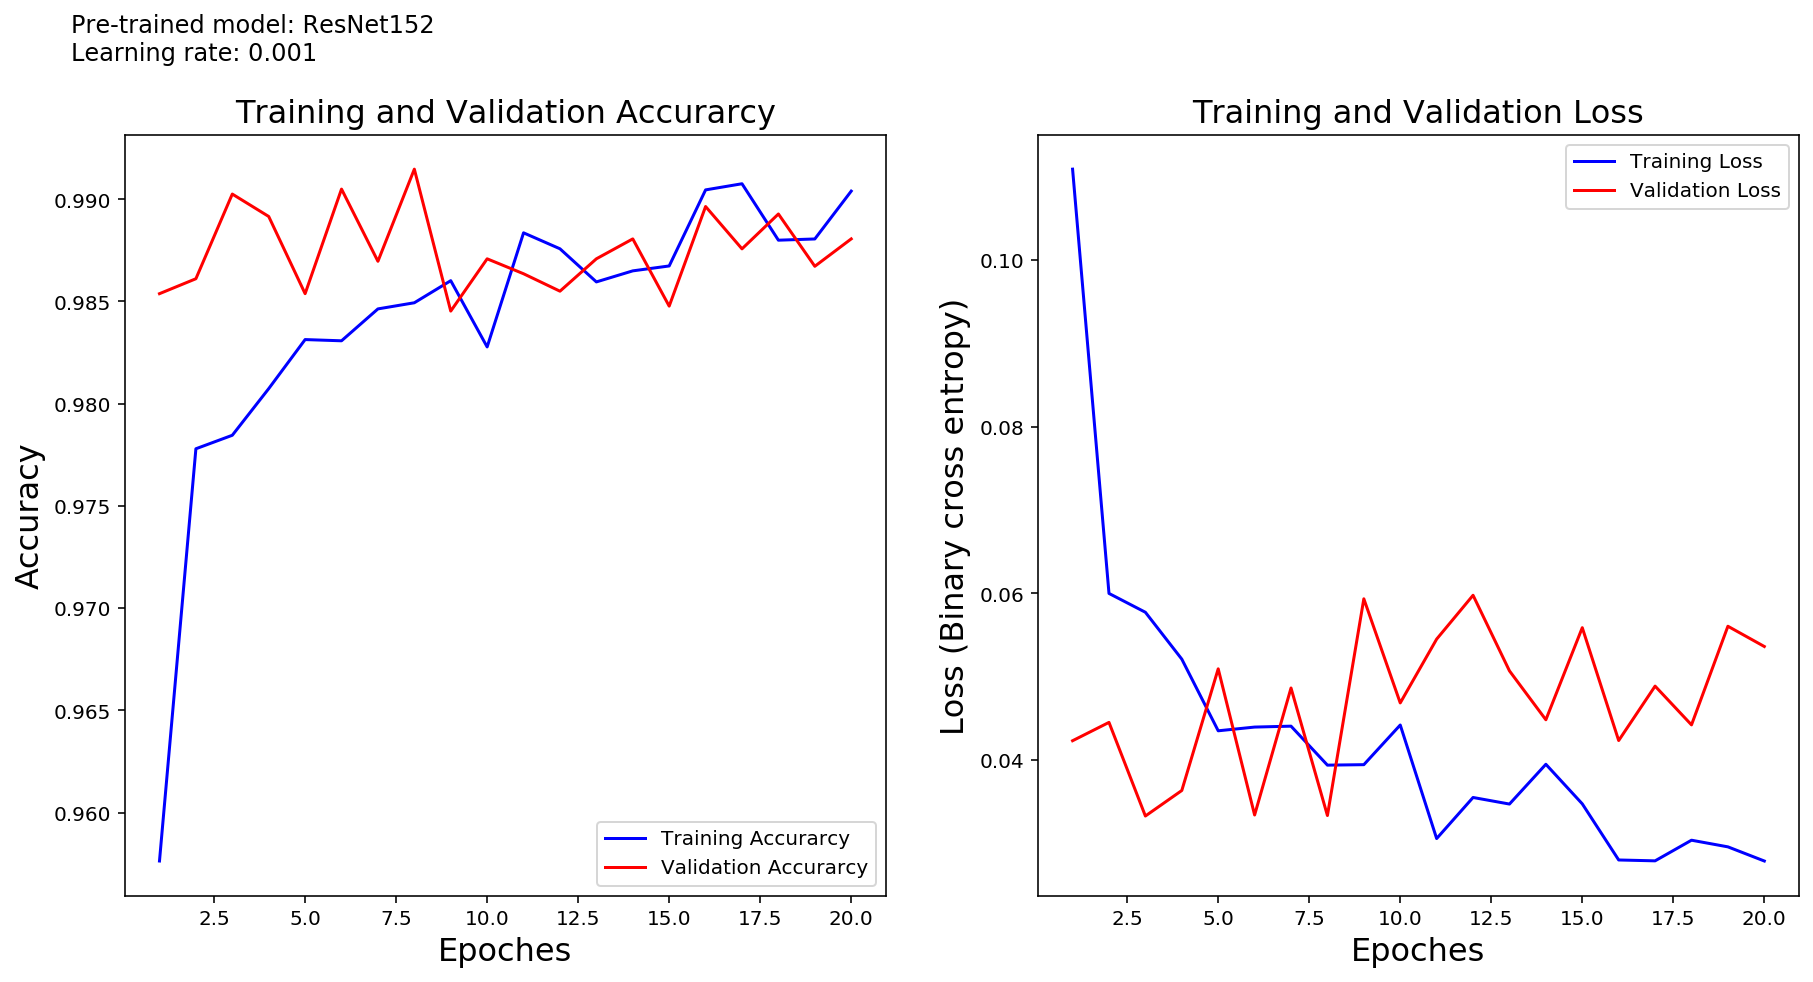

In [69]:
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

x_axis = range(1, epochs+1)

#Train and validation accuracy

plt.figure(figsize = [15, 7])
plt.subplot(1,2,1)
plt.plot(x_axis, acc, 'blue', label='Training Accurarcy')
plt.plot(x_axis, val_acc, 'red', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy', fontsize = 16)
plt.xlabel('Epoches', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.legend()

plt.subplot(1,2,2)
#Train and validation loss
plt.plot(x_axis, loss, 'blue', label='Training Loss')
plt.plot(x_axis, val_loss, 'red', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize = 16)
plt.xlabel('Epoches', fontsize = 16)
plt.ylabel('Loss (Binary cross entropy)', fontsize = 16)
plt.legend()

plt.suptitle('Pre-trained model: {}\nLearning rate: {}'.format(model_name, lr),
            x = 0.1, y = 1, ha = 'left')
plt.savefig('{} loss and acc.jpg'.format(model_name), bbox_inches = 'tight')
plt.show()

# 预测

1.0


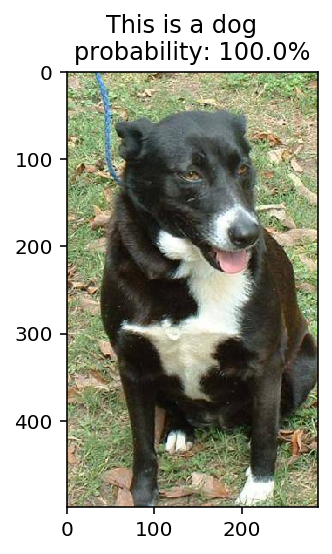

In [63]:
test_imgs = os.listdir(data_dir.format('test'))
img_path = data_dir.format('test') + test_imgs[3]
# img_path = './test04.jpg'
img = image.load_img(img_path, target_size=(im_width, im_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)[0][0]
print(preds)
img_show = mpimg.imread(img_path)
plt.imshow(img_show)
plt.suptitle('This is a {}'.format('dog' if preds > 0.5 else 'cat'))
plt.title('probability: {}%'.format(round(preds*100, 2)) if preds > 0.5 else round((1-preds)*100, 2));

全部预测，制作csv表

In [64]:
test_imgs = os.listdir(data_dir.format('test'))
ids = []
label = []
for i in tqdm(test_imgs):
    img = image.load_img(data_dir.format('test') + i, target_size=(im_width, im_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    label.append(model.predict(x)[0][0])
    ids.append(int(i.split('.')[0]))

100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [05:57<00:00, 34.99it/s]


In [65]:
sub = pd.DataFrame({'id': ids, 'label': label}).sort_values('id',axis = 0, ascending = True)
sub.to_csv('submission.csv', index = False)

# 参考资料

+ https://zhuanlan.zhihu.com/p/26693647
+ https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8
+ https://www.kaggle.com/risingdeveloper/transfer-learning-in-keras-on-dogs-vs-cats